# Power Infrastructure

In this notebook, we will perform a **damage and risk assessment** for power infrastructure. The assessment is based on combining hazard data (e.g., flood depths) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., substations) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on healthcare infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
!pip install damagescanner==0.9b13
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

  Attempting uninstall: damagescanner
    Found existing installation: damagescanner 0.9b5
    Uninstalling damagescanner-0.9b5:
      Successfully uninstalled damagescanner-0.9b5


In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import shapely
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import rioxarray
import contextily as cx

import damagescanner.download as download
from exactextract import exact_extract
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives an error that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Tajikstan'
country_iso3 = 'TJK'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of energy infrastructure (e.g., substations, power poles). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for Rwanda. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. 

In [4]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the healthcare data.

In [43]:
%%time
features = read_osm_data(infrastructure_path,asset_type='power')

CPU times: total: 24.4 s
Wall time: 27.2 s


In [45]:
sub_types = features.object_type.unique()

And we can explore our data interactively 

In [46]:
viz(features)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/100 flood map to showcase the approach.

In [47]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/global_pc_h100glob.tif", engine="rasterio")

In [48]:
hazard_map

<xarray.Dataset> Size: 747GB
Dimensions:      (band: 1, x: 432000, y: 216000)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 3MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 2MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float64 746GB ...

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

Locations of substations (or power plants) are (somewhat randomly) geotagged as either points or polygons. This matters quite a lot for the maximum damages. For polygons, we would use damage per square meter, whereas for points, we would estimate the damage to the entire asset at once. Here we take the approach of converting the points to polygons, and there define our maximum damages in dollar per square meter. 

In [49]:
maxdam_dict = {
    'tower': 1000, 
    'pole': 1000, 
    'portal': 1000, 
    'switch': 1000, 
    'cable': 1000, 
    'generator': 1000, 
    'transformer': 1000, 
    'plant': 1000, 
    'substation': 1000,  
    'line': 1000, 
    'minor_line': 1000, 
     }

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [50]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics.

In [51]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')

And let's have a look at all the available options

In [52]:
with pd.option_context('display.max_rows', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
F1.1,plant,"Small power plants, capacity <100 MW"
F1.2,plant,"Medium power plants, capacity 100-500 MW"
F1.3,plant,"Large power plants, >500 MW"
F1.4,plant,thermal plant
F1.5,plant,wind turbine
F1.6,plant,wind turbine
F1.7,plant,wind turbine
F2.1,substation,Low Voltage Substation
F2.2,substation,Medium Voltage Substation


And select a curve to use for each different subtype we are analysing.

In [53]:
selected_curves = dict(zip(sub_types,['F10.1','F2.3','F6.1','F2.2','F6.1','F1.2','F2.2','F2.2','F2.1','F6.1','F6.1','F6.1']))

In [54]:
selected_curves

{'generator': 'F10.1',
 'tower': 'F2.3',
 'pole': 'F6.1',
 'substation': 'F2.2',
 'portal': 'F6.1',
 'transformer': 'F1.2',
 'terminal': 'F2.2',
 'plant': 'F2.2',
 'line': 'F2.1',
 'minor_line': 'F6.1',
 'cable': 'F6.1'}

The next step is to extract the curves from the database, and prepare them for proper usage into our analysis.

We start by selecting the curve IDs from the larger pandas DataFrame **vul_df**:

In [55]:
damage_curves = vul_df[['ID number']+list(selected_curves.values())]
damage_curves = damage_curves.iloc[4:125,:]

Then for convenience, we rename the index name to the hazard intensity we are considering. 

In [56]:
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('Depth')  

And make sure that our damage values are in floating numbers. 

In [57]:
damage_curves = damage_curves.astype(np.float32)

And ensure that the columns of the curves link back to the different asset types we are considering:

In [58]:
damage_curves.columns = sub_types

There could be some **NaN** values at the tail of some of the curves. To make sure the code works, we fill up the **NaN** values with the last value of each of the curves. 

In [59]:
damage_curves = damage_curves.fillna(method='ffill')

Finally, make sure we set the index of the damage curves (the inundation depth) in the same metric as the hazard data (e.g. meters or centimeters).

In [60]:
damage_curves.index = damage_curves.index*100

### Ancilliary data for processing

In [61]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [62]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Preparing the Data

Clip the hazard data to the country of interest.

In [63]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [64]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

### Convert linestring and point data to polygons. 

For some data, there are both points and polygons available. It makes life easier to estimate the damage using polygons. Therefore, we convert those points to Polygons below. 

Let's first get an overview of the different geometry types for all the assets we are considering in this analysis:

In [65]:
features['geom_type'] = features.geom_type

In [66]:
features.groupby(['object_type','geom_type']).count()['geometry']

object_type  geom_type   
cable        LineString         31
generator    LineString          5
             MultiPolygon        1
             Point              22
line         LineString        993
minor_line   LineString         41
plant        LineString         19
             MultiPolygon       25
             Point               3
pole         Point            4232
portal       LineString          2
             Point             216
substation   LineString        221
             MultiPolygon       13
             Point             108
terminal     Point              80
tower        Point           25192
transformer  LineString          4
             MultiPolygon        1
             Point              73
Name: geometry, dtype: int64

The results above indicate that several asset types that are expected to be *Polygons* (such as **substations** and **plants**) are stored as *LineStrings* and points. It would be preferably to convert them all to polygons. For LineStrings, we can convert them to a *Polygon*, but for the *Points*, we will have to estimate a the average size, so we can use that to create a `buffer` around the assets.

Let's start with all the *LineStrings*. As we do not want to convert all LineStrings, we have to specify which assets we should "polygonize":

In [67]:
linestrings_to_polygonize = ['generator','plant','substation']

all_assets_to_polygonize = features.loc[(features.object_type.isin(linestrings_to_polygonize)) & (features.geometry.geom_type == 'LineString')]

In [68]:
def polygonize_linestring_per_asset(asset):
    return shapely.Polygon(asset.geometry)

collect_new_linestring_geometries = all_assets_to_polygonize.apply(lambda asset:  polygonize_linestring_per_asset(asset),axis=1).values

Now overwrite the *LineStrings* with *Polygons*:

In [69]:
features.loc[(features.object_type.isin(linestrings_to_polygonize)) & (features.geometry.geom_type == 'LineString'),'geometry'] = collect_new_linestring_geometries

And check if any "undesired" *LineStrings* are still left:

In [70]:
features.loc[(features.object_type.isin(linestrings_to_polygonize)) & (features.geometry.geom_type == 'LineString')]

,osm_id,geometry,name,object_type,geom_type


Now, the next step is to create a small buffer around the point data. We first estimate an average size of each building based on each subtype.

To do so, let's grab the polygon data and estimate their size. We grab the median so we are not too much influenced by extreme outliers:

In [71]:
polygon_features = features.loc[features.geometry.geom_type.isin(['Polygon','MultiPolygon'])].to_crs(3857)
polygon_features['square_m2'] = polygon_features.area

square_m2_object_type = polygon_features[['object_type','square_m2']].groupby('object_type').median()
square_m2_object_type

,square_m2
object_type,
generator,409.939423
plant,1232.207672
substation,3921.005272
transformer,83.032844


Now we create, similarly to the *LineStrings*, a list in which we define the assets we want to "polygonize": 

In [72]:
points_to_polygonize = ['generator','plant','substation']

And take them from our data again:

In [73]:
all_assets_to_polygonize = features.loc[(features.object_type.isin(points_to_polygonize)) & (features.geometry.geom_type == 'Point')]

When performing a buffer, it is always best to do this in meters. As such, we will briefly convert the point data into a **crs** system in meters.

In [74]:
all_assets_to_polygonize = all_assets_to_polygonize.to_crs(3857)

In [75]:
def polygonize_point_per_asset(asset):

    # we first need to set a buffer length. This is half of width/length of an asset.
    buffer_length = np.sqrt(square_m2_object_type.loc[asset.object_type].values[0])/2

    # then we can buffer the asset
    return asset.geometry.buffer(buffer_length,cap_style='square')

collect_new_point_geometries = all_assets_to_polygonize.apply(lambda asset:  polygonize_point_per_asset(asset),axis=1).set_crs(3857).to_crs(4326).values

In [76]:
features.loc[(features.object_type.isin(points_to_polygonize)) & (features.geometry.geom_type == 'Point'),'geometry'] = collect_new_point_geometries

And check if any "undesired" *Points* are still left:

In [77]:
features.loc[(features.object_type.isin(points_to_polygonize)) & (features.geometry.geom_type == 'Point')]

,osm_id,geometry,name,object_type,geom_type


And remove the 'geom_type' column again, as we do not need it again.

In [78]:
features = features.drop(['geom_type'],axis=1)

In [79]:
features.loc[features.geometry.is_empty]

,osm_id,geometry,name,object_type


## 5. Performing the Damage Assessment
We will use the DamageScanner approach. This is a fully optimised damage calculation method, that can capture a wide range of inputs to perform a damage assessment.

In [80]:
%%time
damage_results = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate()

Calculating damage: 100%|█████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 13429.63it/s]

CPU times: total: 6.48 s
Wall time: 10.5 s


## 5. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit 

In [81]:
hazard = 'river_flood'
return_period = '1_100'
damage_results.to_csv(f'Power_Damage_{country_full_name}_{hazard}_{return_period}.csv')

In [82]:
admin1_country = admin1.loc[admin1.sov_a3 == country_iso3]

In [83]:
damage_results = damage_results.sjoin(admin1_country[['adm1_code','name','geometry']])

In [84]:
admin1_damage = admin1_country.merge(damage_results[['name_right','damage']].groupby('name_right').sum(),
                                     left_on='name',
                                     right_on='name_right',
                                     how='outer')[['name','adm1_code','geometry','damage']]

In [85]:
admin1_damage.to_csv(f'Admin1_Power_Damage_{country_full_name}_{hazard}_{return_period}.csv')

## 6. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

And create a distribution of the damages.

<Axes: xlabel='damage', ylabel='Count'>

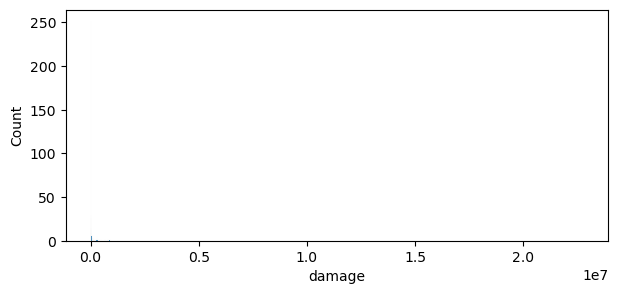

In [86]:
fig, ax = plt.subplots(1,1,figsize=(7, 3))

sns.histplot(data=damage_results,x='damage',ax=ax)

Plot location of most damaged power infrastructure assets.

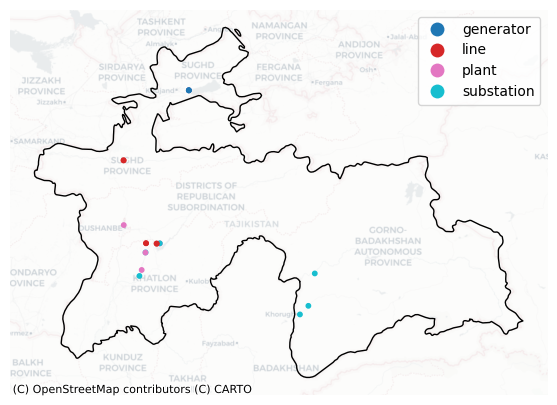

In [88]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

subset = damage_results.to_crs(3857).sort_values('damage',ascending=False).head(20)
subset.geometry = subset.centroid
subset.plot(ax=ax,column='object_type',markersize=10,legend=True)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()